In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
import nltk    
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

stop_words = set(stopwords.words('english')) 

In [3]:
class lemmaTokenizer:
    def __init__(self, stop_words):
        self.stop_words = stop_words
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, doc):
        tokens = word_tokenize(doc.lower())
        filtered_tok = []
        for tok in tokens :
            if  tok not in self.stop_words :
                filtered_tok.append(self.lemmatizer.lemmatize(tok))
        return filtered_tok

In [4]:
#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X])

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

In [5]:
train_df = pd.read_csv("train.csv.zip")
train_df.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
125096,9d21c2a21e0dc83a,Splitting the article\nWhat do other editors t...,0,0,0,0,0,0
106403,3944132a24173add,That sounds fine to me.,0,0,0,0,0,0
35052,5d9baed8989e9533,"""\n\n Happy holidays \n\n Happy holidays. Bes...",0,0,0,0,0,0


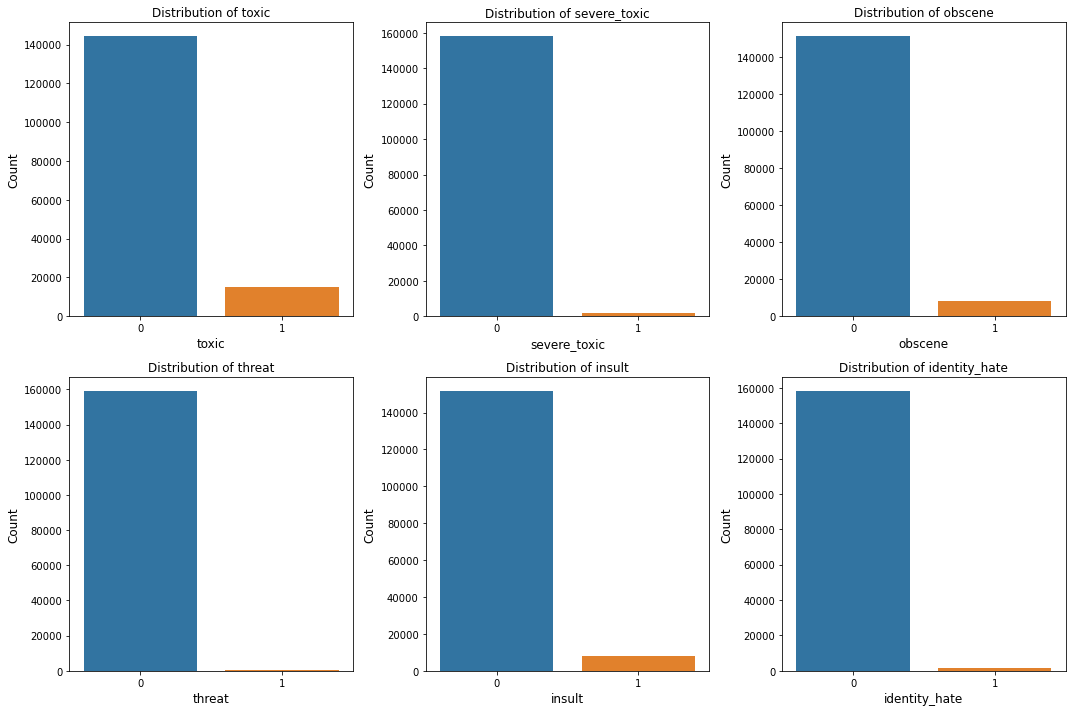

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

# Loop through each column and create countplot
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    sns.countplot(x=col, data=train_df, ax=axs[i])
    axs[i].set_xlabel(col, fontsize=12)
    axs[i].set_ylabel('Count', fontsize=12)
    axs[i].tick_params(labelsize=10)
    axs[i].set_title('Distribution of ' + col, fontsize=12)

# Adjust subplot spacing and display plot
plt.tight_layout()
plt.show()

### Looking at the above distribution of the target variables, the training dataset seems to be imbalanced. We may want to explore using oversampling methods such as SMOTE or ADASYN.

In [ ]:
# The following results were obtained from a RandomForestClassifier (RFC) model before and after SMOTE and ADASYN oversampling
"""
RFC Toxic_model before SMOTE
AUC: 0.9326970920553436
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     36092
           1       0.88      0.49      0.63      3801

    accuracy                           0.94     39893
   macro avg       0.92      0.74      0.80     39893
weighted avg       0.94      0.94      0.94     39893

RFC Toxic_model after SMOTE
AUC: 0.9507946352291728
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     36082
           1       0.70      0.68      0.69      3811

    accuracy                           0.94     39893
   macro avg       0.83      0.82      0.83     39893
weighted avg       0.94      0.94      0.94     39893

"""

"""
RFC severe_toxic_model before SMOTE
AUC: 0.9597362944570248
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39501
           1       0.59      0.13      0.22       392

    accuracy                           0.99     39893
   macro avg       0.79      0.57      0.61     39893
weighted avg       0.99      0.99      0.99     39893

After ADASYN
AUC: 0.9397341602579613
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31594
           1       0.32      0.38      0.35       321

    accuracy                           0.99     31915
   macro avg       0.66      0.69      0.67     31915
weighted avg       0.99      0.99      0.99     31915

After SMOTE
AUC: 0.9384542433527245
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31594
           1       0.34      0.38      0.36       321

    accuracy                           0.99     31915
   macro avg       0.67      0.69      0.68     31915
weighted avg       0.99      0.99      0.99     31915

"""

### Generally, the models' scores were improved after oversampling techniques particularly on f1-score and recall. However, it is also noticeable that the precision dropped on both models after oversampling. At the end, we tried the models on the test_df to predict the target variables but got surprising results.
<ol>

* The RFC models before oversampling techniques predicted 1378 toxic comments and zero(0) severe toxic comments.
* After oversampling, the models predicted 429 toxic comments and 18129 severe toxic comments.
* These results may indicate that the precision have been compromised after oversampling techniques.
</ol>

### We decided not to use oversampling technique and will just tune up the parameters inside the RFC model, i.e n_estimators, max_depth, class_weight etc.

### Exploring other suitable models and hyperparameters

* We run the most common model for text classification, and to see each model's proformance and parameters for training model later.

* MODELS : SVM, Decision Tree Classifier, Random Forest Classifier, Naive Bayes, logistic Regressior.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from numpy import vectorize

In [8]:
sample_train_df = train_df.sample(1000)

In [9]:
x_text = sample_train_df['comment_text']
y = sample_train_df["obscene"]
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(x_text)

In [10]:
model_params  = {
    "svm" : {
        "model":SVC(gamma="auto"),
        "params":{
            'C' : [1,10,20],
            'kernel':["rbf"]
        }
    },
    
    "decision_tree":{
        "model": DecisionTreeClassifier(),
        "params":{
            'criterion':["entropy","gini"],
            "max_depth":[5,8,9]
        }
    },
    
    "random_forest":{
        "model": RandomForestClassifier(),
        "params":{
            "n_estimators":[1,5,10],
            "max_depth":[5,8,9]
        }
    },
    "naive_bayes":{
        "model": GaussianNB(),
        "params":{}
    },
    
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear',multi_class = 'auto'),
        'params': {
            "C" : [1,5,10]
        }
    }
    
}

In [11]:
score=[]
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp["params"],cv=8,return_train_score=False)
    clf.fit(x.toarray(), y)
    score.append({
        "Model" : model_name,
        "Best_Score": clf.best_score_,
        "Best_Params": clf.best_params_
    })

In [12]:
df_result = pd.DataFrame(score,columns=["Model","Best_Score","Best_Params"])
df_result

,Model,Best_Score,Best_Params
0,svm,0.957,"{'C': 1, 'kernel': 'rbf'}"
1,decision_tree,0.971,"{'criterion': 'entropy', 'max_depth': 8}"
2,random_forest,0.958,"{'max_depth': 8, 'n_estimators': 5}"
3,naive_bayes,0.952,{}
4,logistic_regression,0.963,{'C': 10}


In [ ]:
''' 5000 samples
Model	                    Best_Score	Best_Params
0	svm	                    0.946045	{'C': 1, 'kernel': 'rbf'}
1	decision_tree	        0.972094	{'criterion': 'entropy', 'max_depth': 5}
2	random_forest	        0.948029	{'max_depth': 9, 'n_estimators': 5}
3	naive_bayes	            0.946045	{}
4	logistic_regression	    0.964030	{'C': 5}
'''

''' 8000 samples
Model	                    Best_Score	Best_Params
0	svm	                    0.946500	{'C': 20, 'kernel': 'rbf'}
1	decision_tree	        0.972500	{'criterion': 'gini', 'max_depth': 8}
2	random_forest	        0.949125	{'max_depth': 8, 'n_estimators': 1}
3	naive_bayes	            0.899625	{}
4	logistic_regression	    0.972625	{'C': 10}
'''

Decision Tree Classifier, Random Forest Classifier, and logistic Regression seem to have better performance.

But after a sample run, the Decision Tree Classifier and logistic Regression might have overfitting.

We decided to go with Random Forest Classifier.

To get the best parameters of the RFC model, we used GridsearchCV. We sampled out 30000 rows in order for the process to not take long.


In [13]:
sample2_train_df = train_df.sample(30000)

In [14]:
tok = lemmaTokenizer(stop_words=stop_words)
sample2_train_df['clean_text'] = sample2_train_df['comment_text'].apply(lambda x: tok(x))
    
model = Word2Vec(sample2_train_df['clean_text'], min_count=2, vector_size=300, sg=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
    

X_train, X_test, y_train, y_test = train_test_split(sample2_train_df['clean_text'], sample2_train_df['toxic'])
modelw = MeanEmbeddingVectorizer(w2v)
    

X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)

In [15]:
# Using GridSearchCV to get the best parameters for RFC model
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the grid search
param_grid = {'min_samples_leaf': [1, 2],
              'max_features': ['auto', 'sqrt'],
              'class_weight': ['balanced', None]}

# Create a GridSearchCV object with 5-fold cross-validation
rf_grid = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                       param_grid=param_grid, cv=5,
                       scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
rf_grid.fit(X_train_vectors_w2v, y_train)

# Print the best parameters and the corresponding AUC score
print("Best parameters found:", rf_grid.best_params_)
print("AUC score of the best model:", rf_grid.best_score_)

Best parameters found: {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_leaf': 2}
AUC score of the best model: 0.9379766299200556


Now we have an RFC model to use for the whole training dataset.

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [16]:
train_df = pd.read_csv("train.csv.zip")
train_df.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
74148,c66284d99ab298c0,SCARANEESH SCARANEESH sell them childrenNoNonO...,0,0,0,0,0,0
145060,16bb8c622795ce6f,"No, Really! \n\nYou're effing killing me! You...",1,0,0,0,0,0
129425,b44e4b1c6bbaa881,"Hi Pdfpdf, how are you? - Well, I really hate ...",0,0,0,0,0,0


In [17]:
tok = lemmaTokenizer(stop_words)
train_df["clean_text"] = train_df["comment_text"].apply(lambda x: tok(x))
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[d'aww, !, match, background, colour, 'm, seem..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[hey, man, ,, 'm, really, trying, edit, war, ...."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[``, ca, n't, make, real, suggestion, improvem..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[,, sir, ,, hero, ., chance, remember, page, '..."


In [18]:
tmp = pd.DataFrame(w2v)
vectors = model.wv
tmp

,.,",",'',``,),(,:,!,?,article,...,multimedia,talk•email,histmerge,lfdder,staged,assimilating,uncyclopedic,ungrounded,anzick-1,kathmandu
0,0.058299,0.063848,-0.111571,-0.216432,0.164585,0.175037,0.392276,0.242116,-0.098903,0.225348,...,-0.025431,0.011525,0.005302,-0.005266,-0.014043,0.006204,0.006721,0.008879,-0.002894,0.002230
1,0.114778,0.236897,0.120887,0.335803,0.241774,0.352376,-0.067516,0.166901,0.231145,0.320674,...,0.097684,0.073848,0.103790,0.077264,0.137606,0.122488,0.128415,0.115227,0.117435,0.071649
2,-0.064374,-0.069493,-0.359475,-0.234695,-0.091920,-0.145977,-0.170341,0.288646,-0.062716,-0.130093,...,0.036696,0.028519,-0.004741,0.031390,0.008031,0.036948,0.009968,-0.001592,0.036094,0.026064
3,0.244100,0.093584,0.142309,0.235862,0.248742,0.246011,0.224071,0.503050,0.064663,0.150408,...,0.030059,0.043572,0.023795,0.032215,0.036981,0.021840,0.034538,0.000646,0.032490,0.028736
4,-0.197908,-0.034272,-0.160430,-0.069454,0.128460,0.268523,0.097066,-0.202547,-0.318251,0.347130,...,0.062635,0.047556,0.034043,0.025600,0.030052,0.057337,0.034262,0.041978,0.067468,0.051384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.266627,0.030192,0.169507,0.115951,-0.020497,-0.037061,-0.012226,0.201443,0.046361,0.249479,...,0.111425,0.059554,0.085362,0.064425,0.109206,0.108968,0.134694,0.110749,0.090338,0.086387
296,-0.186444,-0.038521,0.016682,0.077378,-0.016620,-0.284148,-0.282873,0.192456,0.356536,0.039197,...,-0.006362,0.007466,-0.012363,0.006566,-0.017081,-0.009305,-0.004445,-0.022392,-0.003174,-0.008019
297,-0.069143,-0.160865,-0.076600,-0.095145,0.134724,0.007841,-0.073932,-0.141942,-0.078528,0.058460,...,-0.045868,-0.028019,-0.064818,-0.031648,-0.053834,-0.047743,-0.054116,-0.057063,-0.065322,-0.048659
298,0.293467,0.232963,-0.051979,0.140757,0.288311,0.251414,-0.036100,0.241023,0.359448,0.100984,...,0.071857,0.061324,0.067194,0.050537,0.077798,0.074978,0.060317,0.064575,0.070890,0.036693


In [19]:
# create Word2vec model
model = Word2Vec(train_df['clean_text'],min_count=2, vector_size=300, sg=1)
#min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

#combination of word and its vector
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Toxic Model

In [20]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(train_df["clean_text"],train_df["toxic"])

#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)
print(X_train_vectors_w2v.shape, X_test_vectors_w2v.shape)
pd.DataFrame(X_train_vectors_w2v)

(119678, 300) (39893, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.055874,0.244217,-0.027840,-0.060415,-0.082235,-0.167085,0.259382,0.305448,-0.062403,-0.095022,...,0.119144,0.175716,0.141766,0.029149,0.215210,0.257888,0.018178,0.032511,0.152097,-0.009925
1,-0.053953,0.215214,-0.011258,-0.042488,-0.109468,-0.239505,0.231558,0.223219,-0.125728,-0.171337,...,0.127274,0.220325,0.118515,0.070659,0.207721,0.247855,0.105462,-0.033805,0.104795,-0.178454
2,-0.108598,0.202354,-0.001864,-0.032542,-0.090465,-0.258095,0.260814,0.265755,-0.108393,-0.172577,...,0.136869,0.229317,0.139455,0.032105,0.234019,0.218607,-0.017373,0.002259,0.173667,-0.140709
3,-0.072870,0.186005,0.011692,-0.029948,-0.095921,-0.236949,0.271339,0.254155,-0.171307,-0.149696,...,0.062223,0.146726,0.133057,-0.004108,0.194000,0.221843,0.041877,-0.020056,0.165014,-0.065323
4,-0.081205,0.171828,-0.023378,-0.086837,0.004038,-0.167111,0.196479,0.208566,-0.070116,-0.064654,...,0.112008,0.201930,0.121813,0.066734,0.225279,0.264480,0.024221,0.008985,0.074660,-0.127946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,0.054045,0.292326,-0.007830,-0.077363,-0.059526,-0.122240,0.346681,0.191058,-0.048837,-0.303597,...,0.163062,0.336950,0.143171,0.154567,0.211030,0.205145,0.045285,0.005366,0.184903,-0.144073
119674,-0.098819,0.202553,0.018073,-0.017650,-0.061985,-0.182100,0.229319,0.229983,-0.106018,-0.171920,...,0.101122,0.239519,0.084001,0.012160,0.176329,0.238173,0.076461,-0.039614,0.138199,-0.132494
119675,-0.084719,0.223220,0.047946,0.007822,-0.011268,-0.234971,0.203474,0.145264,-0.200391,-0.073216,...,0.004734,0.113270,0.074173,-0.061381,0.188710,0.251434,0.023993,-0.099705,0.267636,-0.037506
119676,-0.064193,0.177578,0.018424,-0.072477,0.017225,-0.225646,0.218715,0.241853,-0.174249,-0.145652,...,0.075962,0.174471,0.050851,0.009666,0.183389,0.242305,0.039473,0.059002,0.112419,-0.165793


AUC: 0.949851227559146
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     36044
           1       0.88      0.50      0.63      3849

    accuracy                           0.94     39893
   macro avg       0.91      0.74      0.80     39893
weighted avg       0.94      0.94      0.94     39893



<AxesSubplot:>

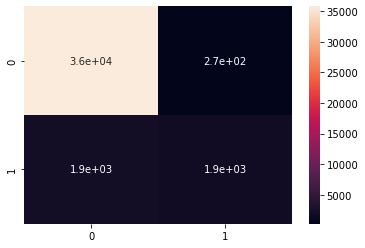

In [21]:
toxic_model = RandomForestClassifier(n_jobs = -1, random_state = 0, class_weight= 'balanced', max_features= 'sqrt', min_samples_leaf= 2)
toxic_model.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = toxic_model.predict(X_test_vectors_w2v)
y_prob = toxic_model.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

Severe Toxic Model

In [22]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train_ST, X_test_ST, y_train_ST, y_test_ST = train_test_split(train_df["clean_text"],train_df["severe_toxic"])

#Word2vec
# Fit and transform
modelw_ST = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v_ST = modelw_ST.transform(X_train_ST)
X_test_vectors_w2v_ST = modelw_ST.transform(X_test_ST)
print(X_train_vectors_w2v_ST.shape, X_test_vectors_w2v_ST.shape)
pd.DataFrame(X_train_vectors_w2v_ST)

(119678, 300) (39893, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.108042,0.156638,-0.041522,-0.035062,-0.135402,-0.137155,0.204557,0.212602,-0.147791,-0.152470,...,0.118360,0.206885,0.046809,0.067368,0.229434,0.254362,0.030373,-0.080299,0.180218,-0.100414
1,-0.073021,0.279651,-0.026031,-0.005365,-0.131429,-0.234896,0.210465,0.206126,-0.049733,-0.179938,...,0.075678,0.164678,0.020385,0.000299,0.172396,0.193977,0.111094,-0.080601,0.169967,-0.150574
2,-0.066630,0.216254,0.079079,-0.196406,-0.245198,-0.210012,0.111040,0.363143,-0.155034,-0.194449,...,0.124836,0.053204,0.176475,0.123415,0.103965,0.310288,-0.037128,0.115647,0.142655,-0.052012
3,-0.125403,0.207016,-0.061289,-0.070930,0.056797,-0.232463,0.177478,0.317782,-0.117417,-0.002012,...,0.114313,0.163466,0.115086,0.050256,0.119965,0.300316,0.017684,0.069137,0.167682,-0.109673
4,-0.111935,0.163633,0.012288,0.018377,-0.053025,-0.188579,0.229431,0.211488,-0.110937,-0.068533,...,0.099264,0.161415,0.081064,0.066340,0.193965,0.282537,0.007635,0.043141,0.173621,-0.126924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,-0.068043,0.203892,0.027149,-0.024197,-0.060990,-0.199811,0.251073,0.206016,-0.088707,-0.098704,...,0.114613,0.189139,0.012299,0.025064,0.210189,0.253308,-0.000198,-0.016106,0.164757,-0.141830
119674,-0.122918,0.185832,0.015470,-0.036387,-0.010865,-0.254229,0.216537,0.257691,-0.264525,-0.169508,...,0.158197,0.241428,0.071241,-0.062869,0.185559,0.203096,0.005351,0.055172,0.239271,-0.056701
119675,-0.143477,0.165400,-0.039520,-0.029032,-0.022138,-0.162562,0.129778,0.246858,-0.013143,-0.038688,...,0.043011,0.150783,0.152634,0.135537,0.259567,0.287416,-0.146267,0.061453,0.153832,-0.098118
119676,-0.078839,0.091856,0.019641,-0.036319,-0.061478,-0.187047,0.187420,0.254713,-0.110562,-0.095045,...,0.067915,0.210739,0.127247,0.045300,0.165239,0.261055,0.000504,0.041157,0.152481,-0.104082


AUC: 0.959362699624393
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39522
           1       0.47      0.20      0.28       371

    accuracy                           0.99     39893
   macro avg       0.73      0.60      0.64     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

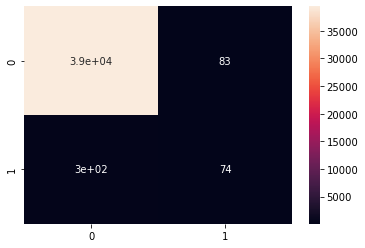

In [23]:
# Make predictions
severetoxic_model = RandomForestClassifier(n_jobs = -1, random_state = 0, class_weight= 'balanced', max_features= 'sqrt', min_samples_leaf= 2)
severetoxic_model.fit(X_train_vectors_w2v_ST, y_train_ST)  #model

#Predict y value for test dataset
ST_y_predict = severetoxic_model.predict(X_test_vectors_w2v_ST)
ST_y_prob = severetoxic_model.predict_proba(X_test_vectors_w2v_ST)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test_ST, ST_y_prob)
ST_roc_auc = auc(fpr, tpr)
print('AUC:', ST_roc_auc)  

print(classification_report(y_test_ST, ST_y_predict))
sns.heatmap(confusion_matrix(y_test_ST, ST_y_predict), annot=True)

Threat Model

In [24]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train_Th, X_test_Th, y_train_Th, y_test_Th = train_test_split(train_df["clean_text"],train_df["threat"])

#Word2vec
# Fit and transform
modelw_Th = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v_Th = modelw_Th.transform(X_train_Th)
X_test_vectors_w2v_Th = modelw_Th.transform(X_test_Th)
pd.DataFrame(X_train_vectors_w2v_Th)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.150814,0.153558,-0.008540,-0.001628,-0.035493,-0.174374,0.136232,0.150867,-0.021170,-0.059598,...,0.039005,0.124294,0.069568,0.078942,0.227579,0.299737,0.022350,-0.041665,0.148746,-0.069853
1,-0.088561,0.143863,-0.014652,-0.000072,-0.095056,-0.168741,0.183983,0.198263,-0.095520,-0.068456,...,0.053793,0.222241,0.051117,0.032268,0.212601,0.283884,0.051682,-0.015158,0.152336,-0.124620
2,-0.193703,0.208211,0.078471,-0.067735,-0.068631,-0.252522,0.318760,0.274150,-0.181196,-0.174775,...,0.161611,0.284070,0.031099,-0.057004,0.247646,0.309179,0.003328,0.129336,0.193605,-0.050567
3,-0.020725,0.185664,0.020734,0.043300,0.042138,-0.239701,0.159911,0.077159,-0.148415,-0.116835,...,0.074697,0.217242,0.126363,0.063694,0.152890,0.294206,0.065936,-0.064537,0.211246,-0.089004
4,-0.027852,0.182297,0.003964,-0.051360,-0.094253,-0.175907,0.282694,0.211447,-0.191843,-0.074109,...,0.080605,0.164350,0.117475,0.021897,0.169681,0.228924,-0.020053,0.031920,0.257276,-0.102856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,-0.063905,0.201146,-0.049369,-0.129445,0.051582,-0.118512,0.129631,0.234729,-0.064194,-0.074314,...,0.065878,0.208771,0.235370,0.072248,0.167264,0.202817,-0.059871,0.057374,0.113993,-0.056375
119674,-0.018989,0.149368,0.015391,0.012818,-0.114702,-0.117457,0.216463,0.193501,-0.137394,-0.131293,...,0.053133,0.216039,0.108002,0.061632,0.253770,0.250723,0.022327,-0.072368,0.091177,-0.119966
119675,-0.127909,0.168548,0.050497,-0.068904,0.047797,-0.194427,0.205872,0.264476,-0.117791,-0.145603,...,0.108791,0.217551,0.197318,0.029490,0.248100,0.193459,0.070677,0.144071,0.153628,-0.079993
119676,-0.136667,0.194543,0.024781,0.009255,-0.090053,-0.078584,0.230408,0.210659,-0.100205,-0.101932,...,0.059923,0.190905,0.066596,-0.007409,0.188631,0.257371,0.054030,-0.044089,0.162114,-0.155728


In [25]:
# Make predictions
threat_model = RandomForestClassifier(n_jobs = -1, random_state = 0, class_weight= 'balanced', max_features= 'sqrt', min_samples_leaf= 2)
threat_model.fit(X_train_vectors_w2v_Th, y_train_Th)  #model

#Predict y value for test dataset
Th_y_predict = threat_model.predict(X_test_vectors_w2v_Th)
Th_y_prob = threat_model.predict_proba(X_test_vectors_w2v_Th)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test_Th, Th_y_prob)
Th_roc_auc = auc(fpr, tpr)
print('AUC:', Th_roc_auc)  

print(classification_report(y_test_Th, Th_y_predict))

AUC: 0.9225560182431094
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39770
           1       0.67      0.08      0.14       123

    accuracy                           1.00     39893
   macro avg       0.83      0.54      0.57     39893
weighted avg       1.00      1.00      1.00     39893



Identity Hate Model

In [26]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train_IH, X_test_IH, y_train_IH, y_test_IH = train_test_split(train_df["clean_text"],train_df["identity_hate"])

#Word2vec
# Fit and transform
modelw_IH = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v_IH = modelw_IH.transform(X_train_IH)
X_test_vectors_w2v_IH = modelw_IH.transform(X_test_IH)
print(X_train_vectors_w2v_IH.shape, X_test_vectors_w2v_IH.shape)
pd.DataFrame(X_train_vectors_w2v_IH)

(119678, 300) (39893, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.052452,0.247858,-0.068585,0.058882,-0.113417,-0.180910,0.333305,0.185624,-0.103139,-0.079784,...,0.111840,0.129977,-0.002319,-0.031646,0.284053,0.329334,-0.010977,0.094444,0.196423,-0.168426
1,-0.070346,0.268159,-0.020783,-0.022888,-0.134959,-0.144370,0.161459,0.184464,-0.154817,-0.139936,...,0.055656,0.099790,0.213826,-0.052687,0.305880,0.148807,0.036678,0.064346,0.119069,-0.174116
2,-0.138034,0.197527,-0.038410,-0.072825,0.035153,-0.202648,0.195165,0.155370,-0.142116,-0.134152,...,0.052224,0.189657,0.142415,0.038336,0.245078,0.225058,0.094458,-0.074817,0.196084,-0.082121
3,-0.120050,0.237035,0.042883,-0.038957,-0.072957,-0.234723,0.245809,0.241853,-0.188203,-0.181862,...,0.075931,0.167329,0.055622,-0.022901,0.182600,0.223812,0.026714,-0.053800,0.222471,-0.118742
4,-0.065523,0.174026,0.070441,0.014119,-0.073562,-0.062102,0.237466,0.178197,-0.061490,-0.030173,...,0.034646,0.193166,0.078200,0.064305,0.232668,0.248519,0.033642,-0.032123,0.166828,-0.069573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,-0.130976,0.132688,-0.018329,-0.157532,-0.082035,-0.259800,0.241800,0.281923,-0.119407,0.010344,...,0.091920,0.223034,0.128904,0.084714,0.211275,0.227555,-0.118160,0.228542,0.205625,-0.052172
119674,-0.112543,0.204797,0.036526,-0.077202,-0.020043,-0.211659,0.161597,0.255466,-0.062101,-0.179006,...,0.126122,0.209783,0.128253,0.014660,0.181886,0.226069,0.073899,0.003756,0.171068,-0.157920
119675,0.017625,0.184602,0.006417,-0.130647,-0.046782,-0.223671,0.120573,0.255806,-0.127804,-0.140019,...,0.209366,0.233613,0.170595,0.110919,0.291915,0.228631,-0.018176,-0.035796,0.095518,-0.125593
119676,-0.063514,0.236476,-0.026296,-0.061830,-0.007000,-0.280811,0.146132,0.350215,-0.187345,-0.151974,...,0.182518,0.184688,0.136868,-0.009973,0.201993,0.227549,-0.009073,-0.000157,0.168123,-0.176607


In [27]:
# Make predictions
IdenHate_model = RandomForestClassifier(n_jobs = -1, random_state = 0, class_weight= 'balanced', max_features= 'sqrt', min_samples_leaf= 2)
IdenHate_model.fit(X_train_vectors_w2v_IH, y_train_IH)  #model

#Predict y value for test dataset
IH_y_predict = IdenHate_model.predict(X_test_vectors_w2v_IH)
IH_y_prob = IdenHate_model.predict_proba(X_test_vectors_w2v_IH)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test_IH, IH_y_prob)
IH_roc_auc = auc(fpr, tpr)
print('AUC:', IH_roc_auc)  

print(classification_report(y_test_IH, IH_y_predict))

AUC: 0.9517128146980427
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39554
           1       0.62      0.14      0.23       339

    accuracy                           0.99     39893
   macro avg       0.81      0.57      0.61     39893
weighted avg       0.99      0.99      0.99     39893



Obscene Model

In [28]:
X_train_OB, X_test_OB, y_train_OB, y_test_OB = train_test_split(train_df["clean_text"],train_df["obscene"])
modelw_OB = MeanEmbeddingVectorizer(w2v)


X_train_vectors_w2v_OB = modelw_OB.transform(X_train_OB)
X_test_vectors_w2v_OB = modelw_OB.transform(X_test_OB)

print(X_train_vectors_w2v_OB.shape, X_test_vectors_w2v_OB.shape)
pd.DataFrame(X_train_vectors_w2v_OB)

(119678, 300) (39893, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.049615,0.215741,-0.000521,-0.061210,-0.199817,-0.311428,0.219244,0.243215,-0.096844,-0.156019,...,0.163499,0.159593,0.078909,0.051033,0.208511,0.197792,0.096225,-0.068411,0.149097,-0.126187
1,-0.122663,0.170981,0.052844,-0.082948,-0.082208,-0.227492,0.222201,0.261226,-0.188627,-0.103327,...,0.116167,0.237499,0.066337,0.037196,0.152030,0.229269,0.100410,-0.015768,0.194134,-0.136206
2,-0.179589,0.206105,0.006614,-0.000289,-0.007822,-0.257220,0.158980,0.270103,-0.047700,-0.241805,...,0.084374,0.167919,0.024127,0.018471,0.154459,0.196551,0.126292,-0.111216,0.120957,-0.035853
3,-0.110109,0.179623,0.063774,-0.056544,-0.092911,-0.280632,0.245265,0.314175,-0.142379,-0.150216,...,0.149075,0.211355,0.130250,-0.008173,0.173107,0.277009,0.038009,0.053995,0.214243,-0.151781
4,-0.121343,0.149354,0.002266,-0.054425,-0.072285,-0.240403,0.286311,0.252530,-0.097521,-0.052476,...,0.064137,0.218345,0.177290,0.066034,0.196436,0.224860,0.015666,-0.000937,0.243052,-0.119816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,-0.106910,0.385495,-0.148397,-0.109631,-0.094599,-0.210579,0.201228,0.340012,-0.176492,-0.105761,...,-0.003327,0.240437,0.173783,-0.099739,0.238892,0.247729,-0.050606,0.092592,0.057311,-0.168283
119674,-0.086480,0.143127,-0.022520,-0.018202,-0.155187,-0.125961,0.052696,0.255869,0.026551,-0.125462,...,0.030063,0.108407,0.147904,0.026417,0.254780,0.353115,0.028856,0.023379,0.054675,-0.009261
119675,-0.066630,0.216254,0.079079,-0.196406,-0.245198,-0.210012,0.111040,0.363143,-0.155034,-0.194449,...,0.124836,0.053204,0.176475,0.123415,0.103965,0.310288,-0.037128,0.115647,0.142655,-0.052012
119676,-0.114732,0.259318,0.112030,0.060879,-0.063481,-0.148151,0.161176,0.321447,-0.041287,-0.130298,...,0.149843,0.218250,0.104249,-0.075515,0.166044,0.228244,0.003438,-0.085790,0.179109,-0.093916


In [29]:
# Make predictions
OB_model = RandomForestClassifier()
OB_model.fit(X_train_vectors_w2v_OB, y_train_OB)

y_predict_OB = OB_model.predict(X_test_vectors_w2v_OB)
y_prob_OB = OB_model.predict_proba(X_test_vectors_w2v_OB)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test_OB, y_prob_OB)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc) 
print(classification_report(y_test_OB, y_predict_OB))

AUC: 0.9457867834976268
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     37818
           1       0.90      0.47      0.62      2075

    accuracy                           0.97     39893
   macro avg       0.94      0.73      0.80     39893
weighted avg       0.97      0.97      0.97     39893



Insult Model

In [30]:
X_train_In, X_test_In, y_train_In, y_test_In = train_test_split(train_df["clean_text"],train_df["insult"])
modelw_In = MeanEmbeddingVectorizer(w2v)


X_train_vectors_w2v_In = modelw_In.transform(X_train_In)
X_test_vectors_w2v_In = modelw_In.transform(X_test_In)

print(X_train_vectors_w2v_In.shape, X_test_vectors_w2v_In.shape)
pd.DataFrame(X_train_vectors_w2v_In)

(119678, 300) (39893, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.076299,0.177462,0.048670,0.109725,0.019200,-0.271021,0.112491,0.287859,-0.092511,-0.124849,...,0.045582,0.283879,0.123273,-0.108078,0.217287,0.185666,0.011218,-0.019935,0.222594,-0.054233
1,-0.136561,0.122760,0.071097,0.028517,-0.036605,-0.181885,0.193082,0.262406,-0.019150,-0.112978,...,0.013424,0.276550,0.272130,0.118734,0.190579,0.146708,0.008921,-0.063874,0.184481,-0.043920
2,-0.075830,0.247128,0.005949,-0.042547,-0.026215,-0.168398,0.209457,0.276571,-0.100684,-0.177132,...,0.076001,0.218922,0.123111,-0.012572,0.182064,0.180949,-0.005001,0.085982,0.132886,-0.194817
3,-0.116194,0.167378,0.048064,-0.054991,-0.000572,-0.268833,0.138259,0.278334,-0.116326,-0.128179,...,0.035605,0.269585,0.147867,0.059362,0.200618,0.251813,0.020061,-0.044460,0.155468,-0.108137
4,-0.025117,0.134579,-0.030581,-0.061906,-0.049409,-0.246077,0.126151,0.226484,-0.185278,-0.121754,...,0.169352,0.197433,0.184787,-0.036146,0.226106,0.181110,0.027135,-0.090710,0.193612,-0.123254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,-0.034985,0.183851,0.027355,0.041044,-0.073239,-0.054226,0.205180,0.224517,-0.013038,-0.177203,...,0.119685,0.230541,0.102672,0.116155,0.224787,0.221424,0.052411,-0.023720,0.147871,-0.076871
119674,-0.136327,0.266768,-0.034069,0.023148,-0.164965,-0.318951,0.138575,0.298791,-0.017950,-0.120991,...,0.085792,0.199125,0.046020,0.216149,0.263708,0.312604,0.025662,-0.019392,0.034530,-0.098254
119675,-0.072429,0.220032,0.028851,-0.011362,-0.117682,-0.176594,0.187307,0.234107,-0.099513,-0.064842,...,0.053277,0.205032,0.090530,-0.009416,0.170003,0.229131,0.042517,-0.032801,0.167264,-0.096150
119676,-0.121562,0.145759,-0.023254,0.020397,-0.086182,-0.108836,0.237569,0.210972,-0.102414,-0.080773,...,0.117111,0.208172,0.046143,0.035933,0.201731,0.278258,0.009171,-0.012326,0.148719,-0.118475


In [31]:
# Make predictions
Insult_model = RandomForestClassifier()
Insult_model.fit(X_train_vectors_w2v_In, y_train_In)

y_predict_In = Insult_model.predict(X_test_vectors_w2v_In)
y_prob_In = Insult_model.predict_proba(X_test_vectors_w2v_In)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test_In, y_prob_In)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc) 
print(classification_report(y_test_In, y_predict_In))

AUC: 0.9379047116372159
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     37947
           1       0.81      0.42      0.55      1946

    accuracy                           0.97     39893
   macro avg       0.89      0.71      0.77     39893
weighted avg       0.96      0.97      0.96     39893



Although in general the accuracy of our final model is high, it is somehow having difficulties predicting target variables that are very low in counts such as the severe_toxic, threat and identity_hate as reflected on their f1-scores of 0.32, 0.14 and 0.25, respectively.

## Test Data

In [33]:
test_df = pd.read_csv('test.csv')
tok = lemmaTokenizer(stop_words=stop_words)
test_df['clean_text'] = test_df['comment_text'].apply(lambda x: (tok(x)))
# create Word2vec model
test = Word2Vec(test_df['clean_text'], min_count = 2, vector_size = 300, sg = 1)
test_w2v = dict(zip(test.wv.index_to_key, test.wv.vectors)) 

In [34]:
testw = MeanEmbeddingVectorizer(test_w2v)
test_vectors = testw.transform(test_df["clean_text"])
print(test_vectors.shape)
pd.DataFrame(test_vectors)

(153164, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.055201,-0.150612,-0.035569,-0.152634,0.152053,0.029742,-0.063537,0.299461,0.184763,0.108145,...,0.017165,0.132340,0.021967,0.095133,0.202271,0.058625,0.215362,0.119273,0.093392,0.018274
1,-0.114263,-0.079369,-0.211238,0.093145,0.038758,-0.047164,0.027371,0.265045,0.127202,0.109241,...,0.053674,0.172464,0.042809,0.058235,0.229962,0.154217,0.228001,-0.065258,0.096375,-0.241245
2,-0.025808,-0.040806,-0.265002,0.091568,0.196788,0.022114,0.037464,0.172367,0.003711,0.164147,...,0.022060,0.322563,0.071119,-0.038720,0.225001,0.085738,0.150080,-0.221515,0.095214,-0.205111
3,-0.048865,-0.113270,-0.221400,0.107247,0.036995,-0.047481,0.152740,0.359466,0.091587,0.191358,...,0.084328,0.298638,-0.054102,0.085479,0.279424,0.110128,0.201924,-0.057929,0.063105,-0.216837
4,0.009670,-0.103263,-0.288295,-0.088466,-0.028198,0.040992,0.156282,0.353921,0.110072,-0.002937,...,0.126334,0.330577,0.022643,0.094289,0.288221,0.164517,0.112930,-0.012753,0.120101,-0.342887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153159,-0.027394,-0.132996,-0.319799,-0.161095,-0.057607,-0.101171,0.118599,0.360904,0.193937,0.024362,...,0.023471,0.299337,0.027422,0.073347,0.231744,0.186034,0.131905,-0.011249,-0.026247,-0.054599
153160,-0.003697,-0.006466,0.012573,-0.005103,0.045230,-0.004657,0.075040,0.265033,0.098261,0.096755,...,0.013929,0.187065,0.000504,0.083947,0.277969,0.121471,0.182416,0.017408,0.182431,-0.111798
153161,-0.068146,-0.089727,-0.189245,0.027235,0.038152,-0.073132,0.089066,0.237970,0.108128,0.164419,...,0.032483,0.259653,-0.001374,0.071231,0.211157,0.225671,0.180421,-0.046809,0.136371,-0.129765
153162,-0.047476,-0.013166,-0.173263,0.044133,0.055374,-0.059368,0.026533,0.219156,0.121567,0.114140,...,0.011572,0.271990,0.062070,0.040823,0.230648,0.268138,0.175075,-0.006215,0.176035,-0.125672


In [35]:
toxic_predict = toxic_model.predict(test_vectors)
toxic = pd.DataFrame(toxic_predict)
toxic.value_counts()

0    152856
1       308
dtype: int64

In [36]:
severetoxic_predict = severetoxic_model.predict(test_vectors)
severe_toxic = pd.DataFrame(severetoxic_predict)
severe_toxic.value_counts()

0    152856
1       308
dtype: int64

In [37]:
threat_predict = threat_model.predict(test_vectors)
threat = pd.DataFrame(threat_predict)
threat.value_counts()

0    153164
dtype: int64

In [38]:
idenhate_predict = IdenHate_model.predict(test_vectors)
identity_hate = pd.DataFrame(idenhate_predict)
identity_hate.value_counts()

0    152856
1       308
dtype: int64

In [39]:
obscene_predict = OB_model.predict(test_vectors)
obscene = pd.DataFrame(obscene_predict)
obscene.value_counts()

0    153117
1        47
dtype: int64

In [40]:
insult_predict = Insult_model.predict(test_vectors)
insult = pd.DataFrame(insult_predict)
insult.value_counts()

0    153144
1        20
dtype: int64

In [42]:
targets = {
    "toxic": toxic,
    "severe_toxic": severe_toxic,
    "obscene": obscene,
    "threat": threat,
    "insult": insult,
    "identity_hate": identity_hate}

columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df_out = pd.DataFrame(columns = ['id'] + columns)


for i in columns :
    df_out['id'] = test_df['id'].astype('object')
    df_out = df_out[['id'] + columns]
    df_out[i] = targets[i]


df_out.to_csv('out_1.csv', index = False)
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             153164 non-null  object
 1   toxic          153164 non-null  int64 
 2   severe_toxic   153164 non-null  int64 
 3   obscene        153164 non-null  int64 
 4   threat         153164 non-null  int64 
 5   insult         153164 non-null  int64 
 6   identity_hate  153164 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.2+ MB


## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
'''
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()
'''

In [ ]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
#sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>